In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
ls

README.md                               discrete_anomaly_detection.ipynb
continuous_probabilistic_methods.ipynb  env.py
curr_access.csv                         lemonade.csv
curriculum-access.txt


In [3]:
colnames=['date', 'time', 'request_url', 'user_id', 'cohort', 'ip']

df = pd.read_csv('curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"'
)

In [4]:
df.head()

,date,time,request_url,user_id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62
2,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
3,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62
4,2018-01-26,09:56:41,javascript-i/loops,2,22.0,98.106.20.62


In [5]:
df.shape

(543595, 6)

In [6]:
df['timestamp'] = df[['date', 'time']].agg(' '.join, axis=1)

In [7]:
df.head()

,date,time,request_url,user_id,cohort,ip,timestamp
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62,2018-01-26 09:56:02
2,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62,2018-01-26 09:56:06
3,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62,2018-01-26 09:56:24
4,2018-01-26,09:56:41,javascript-i/loops,2,22.0,98.106.20.62,2018-01-26 09:56:41


In [8]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp) 
# df = df.set_index('timestamp')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543595 entries, 0 to 543594
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         543595 non-null  object        
 1   time         543595 non-null  object        
 2   request_url  543594 non-null  object        
 3   user_id      543595 non-null  int64         
 4   cohort       515739 non-null  float64       
 5   ip           543595 non-null  object        
 6   timestamp    543595 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 29.0+ MB


In [10]:
df.describe()

,user_id,cohort
count,543595.000000,515739.000000
mean,329.355049,32.625925
std,178.595241,12.699322
min,1.000000,1.000000
25%,195.000000,24.000000
50%,344.000000,29.000000
75%,476.000000,34.000000
max,650.000000,57.000000


In [11]:
df.isna().sum()

date               0
time               0
request_url        1
user_id            0
cohort         27856
ip                 0
timestamp          0
dtype: int64

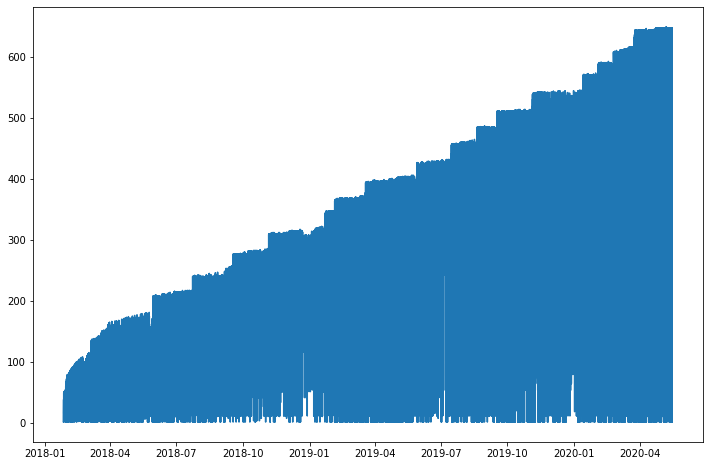

In [12]:
plt.figure(figsize=(12,8))
plt.plot(df.timestamp, df.user_id)
plt.show()

In [13]:

df.request_url.isna().sum()

1

In [14]:
df[df.user_id == 586].isna().sum()

date           0
time           0
request_url    1
user_id        0
cohort         0
ip             0
timestamp      0
dtype: int64

In [15]:
# what is the index of the null request_url
df[df.request_url.isna()].user_id == 586

506304    True
Name: user_id, dtype: bool

In [16]:
# what does the row look like where request_url == NaN 
df.iloc[506304]

date                    2020-04-08
time                      09:25:18
request_url                    NaN
user_id                        586
cohort                          55
ip                   73.178.241.52
timestamp      2020-04-08 09:25:18
Name: 506304, dtype: object

In [17]:
df.user_id.value_counts()

11     11065
64     10784
53      9534
1       5436
344     5370
       ...  
593        1
592        1
649        1
66         1
163        1
Name: user_id, Length: 650, dtype: int64

- Can you label students who are viewing both the web dev and data science curriculum? 

In [18]:
# function that takes in a url topic and returns a course name
def get_course(topic):
    if type(topic) != str:
        return "Unknown"
    # Recommend using boolean flag variables to simplify
    exists_in_web_dev = False
    exists_in_ds = False
    wd = ['javascript', 'java', 'css', 'mysql', 'jquery', 'spring', 'html']
    ds = ['anomaly', 'timeseries', 'python', 'mysql', 'regression', 'classification']
    for w in wd:
        if w in topic:
            exists_in_web_dev = True
    for d in ds:
        if d in topic:
            exists_in_ds = True
    if exists_in_ds and exists_in_web_dev:
        answer = "Both"
    elif exists_in_ds:
        answer = "Data Science"
    elif exists_in_web_dev:
        answer = "Web Dev"
    else:
        answer = "Unknown"
    return answer

In [19]:
df['course'] = df.request_url.apply(get_course)
df.head()

,date,time,request_url,user_id,cohort,ip,timestamp,course
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62,2018-01-26 09:55:03,Unknown
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62,2018-01-26 09:56:02,Web Dev
2,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62,2018-01-26 09:56:06,Unknown
3,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62,2018-01-26 09:56:24,Web Dev
4,2018-01-26,09:56:41,javascript-i/loops,2,22.0,98.106.20.62,2018-01-26 09:56:41,Web Dev


- Can you label students by the program they are in? 

In [20]:
df[df.course == 'Data Science']

,date,time,request_url,user_id,cohort,ip,timestamp,course
273792,2019-05-30,11:35:46,python,11,28.0,98.106.20.59,2019-05-30 11:35:46,Data Science
291301,2019-07-02,08:52:32,4-python/4-control-structures,1,28.0,98.106.20.59,2019-07-02 08:52:32,Data Science
291302,2019-07-02,08:52:36,4-python/5-functions,1,28.0,98.106.20.59,2019-07-02 08:52:36,Data Science
291333,2019-07-02,09:05:49,4-python/5-functions,1,28.0,98.106.20.59,2019-07-02 09:05:49,Data Science
291334,2019-07-02,09:07:13,4-python/5-functions,1,28.0,98.106.20.59,2019-07-02 09:07:13,Data Science
...,...,...,...,...,...,...,...,...
543577,2020-05-15,14:52:13,10-anomaly-detection/3-discrete-probabilistic-...,11,28.0,77.186.132.227,2020-05-15 14:52:13,Data Science
543578,2020-05-15,14:52:38,10-anomaly-detection/2-continuous-probabilisti...,11,28.0,77.186.132.227,2020-05-15 14:52:38,Data Science
543589,2020-05-15,15:00:58,9-timeseries/4-explore,588,55.0,71.95.165.84,2020-05-15 15:00:58,Data Science
543591,2020-05-15,15:01:54,9-timeseries/3-prep,582,55.0,48.135.163.38,2020-05-15 15:01:54,Data Science


In [21]:
df[df.course == 'Web Dev']

,date,time,request_url,user_id,cohort,ip,timestamp,course
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62,2018-01-26 09:56:02,Web Dev
3,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62,2018-01-26 09:56:24,Web Dev
4,2018-01-26,09:56:41,javascript-i/loops,2,22.0,98.106.20.62,2018-01-26 09:56:41,Web Dev
5,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,98.106.20.62,2018-01-26 09:56:46,Web Dev
6,2018-01-26,09:56:48,javascript-i/functions,3,22.0,98.106.20.62,2018-01-26 09:56:48,Web Dev
...,...,...,...,...,...,...,...,...
543587,2020-05-15,15:00:26,spring/fundamentals/relationships,120,53.0,105.49.214.176,2020-05-15 15:00:26,Web Dev
543588,2020-05-15,15:00:27,spring/fundamentals/form-model-binding,120,53.0,105.49.214.176,2020-05-15 15:00:27,Web Dev
543590,2020-05-15,15:01:40,java-ii/file-io,602,56.0,48.188.241.68,2020-05-15 15:01:40,Web Dev
543592,2020-05-15,15:03:37,jquery/ajax/requests-and-responses,637,57.0,71.121.18.17,2020-05-15 15:03:37,Web Dev


- Can you label users by student vs. staff? 

- What are Zach, Maggie, David, and Ryan's ids?

In [22]:
df.user_id.value_counts()

11     11065
64     10784
53      9534
1       5436
344     5370
       ...  
593        1
592        1
649        1
66         1
163        1
Name: user_id, Length: 650, dtype: int64

- Can you label students who are viewing both the web dev and data science curriculum? 

In [23]:
df[df.course == 'Both']

,date,time,request_url,user_id,cohort,ip,timestamp,course
148,2018-01-26,11:48:17,mysql,16,21.0,98.106.20.62,2018-01-26 11:48:17,Both
233,2018-01-26,13:51:13,mysql,36,21.0,98.106.20.62,2018-01-26 13:51:13,Both
234,2018-01-26,13:51:15,mysql/users,36,21.0,98.106.20.62,2018-01-26 13:51:15,Both
235,2018-01-26,13:51:17,mysql/sample-database,36,21.0,98.106.20.62,2018-01-26 13:51:17,Both
237,2018-01-26,13:51:24,mysql/functions,36,21.0,98.106.20.62,2018-01-26 13:51:24,Both
...,...,...,...,...,...,...,...,...
543353,2020-05-15,13:31:25,mysql/databases,600,56.0,108.199.57.205,2020-05-15 13:31:25,Both
543550,2020-05-15,14:42:37,mysql,598,56.0,73.183.215.181,2020-05-15 14:42:37,Both
543551,2020-05-15,14:42:43,mysql/introduction,598,56.0,73.183.215.181,2020-05-15 14:42:43,Both
543552,2020-05-15,14:42:43,mysql/users,598,56.0,73.183.215.181,2020-05-15 14:42:43,Both


In [24]:
df.to_csv('curr_access.csv')